# MBTA Bus Priority Lanes Review

## Contents:
1. Code to load and filter the necessary data
2. Descriptive statistics of travel before and after the implementation
3. Plots of travel time distributions along the route 
4. An interactive plot for visualizing the data

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from dateutil.parser import parse
from ipywidgets import interact

In [200]:
# Read in the data for Mass Ave Route 1
path_r1_in = '/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 3/AVL Data/South Mass Ave/r1_in.csv'
path_r1_out = '/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 3/AVL Data/South Mass Ave/r1_out.csv'
path_r71_in = '/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 3/AVL Data/Mt Auburn St/r71_in.csv'
path_r71_out = '/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 3/AVL Data/Mt Auburn St/r71_out.csv'
path_r73_in = '/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 3/AVL Data/Mt Auburn St/r73_in.csv'
path_r73_out = '/Users/ASKalila 1/Dropbox (MIT)/DUSP SM/Public Transit/Assignment 3/AVL Data/Mt Auburn St/r73_out.csv'

with open(path_r1_in, 'r') as inp:
    r1_in = pd.read_csv(inp)   
with open(path_r1_out, 'r') as inp:
    r1_out = pd.read_csv(inp)   
with open(path_r71_in, 'r') as inp:
    r71_in = pd.read_csv(inp)
with open(path_r71_out, 'r') as inp:
    r71_out = pd.read_csv(inp)
with open(path_r73_in, 'r') as inp:
    r73_in = pd.read_csv(inp)
with open(path_r73_out, 'r') as inp:
    r73_out = pd.read_csv(inp)
    

In [197]:
def analyze_route(df):
    """
    Function to produce 5 metrics on travel time for each of three daily times: 
    1. range
    2. lower quartile or 25th percentile
    3. 50th percentile or median
    4. upper quartile or 75th percentile
    5. standard deviation
    
    input: dataframe of stop arrival times
    output: text with calcualtions
    
    """
    
    
    
    cols = list()
    for x in df.columns:
        try: 
            if type(int(x)) == int: cols.append(x)
        except: pass

    # Compute time differences 

    for col in cols:
        df[col] = pd.to_datetime(df[col])
    df['time1'] = df[cols[1]] - df[cols[0]]
    df['time2'] = df[cols[2]] - df[cols[1]]
    df['time3'] = df[cols[3]] - df[cols[2]]
    df['time4'] = df[cols[3]]- df[cols[0]] # combined stop times
    
    df['time1_sec'] = df['time1'].dt.total_seconds()
    df['time2_sec'] = df['time2'].dt.total_seconds()
    df['time3_sec'] = df['time3'].dt.total_seconds()
    df['time4_sec'] = df['time4'].dt.total_seconds() # combined stop times
    
    # Label the time period based on the arrival at the first stop
    def time_period(row):
        am_start,am_end = dt.time(7,30,0), dt.time(9,30,0) # 7:30 to 9:30 am
        midday_start, midday_end = dt.time(12,30,0), dt.time(14,0,0) # 12 to 2 pm
        pm_start, pm_end = dt.time(16,30,0), dt.time(18,30,0) # 4:30 to 6:30 pm
        try: 
            if am_start < row[cols[0]].time() < am_end: return 1
            elif midday_start < row[cols[0]].time() < midday_end: return 2
            elif pm_start < row[cols[0]].time() < pm_end: return 3
            else: return 4
        except: return 0
    df['period'] = df.apply(time_period,axis=1)
    
    # Produce 5 metric changes for each time period
    
    time_periods = ['AM Peak', 'Midday','PM_Peak']
    for i, period in enumerate(time_periods):
        
        print(f'---------------------------- {period} ----------------------------')
        print('Changes in \tFirst leg \tSecond Leg \tThird Leg \tCombined')
        # Compute all metrics for before implementation:
        period_df = df[df.period == i+1][df.prepostm == 0] # filter the df into time periods
        r_b4, low_q_b4,median_b4,up_q_b4, std_b4 = list(),list(),list(),list(),list()

        for stop in range(1,5):
            column_name = 'time'+str(stop)+'_sec'
            r_b4.append((max(period_df[period_df[column_name] > 0][column_name]) - min(period_df[period_df[column_name] > 0][column_name]))/60)
            low_q_b4.append(np.nanpercentile(period_df[period_df[column_name]>0][column_name],25)/60)
            median_b4.append(np.nanpercentile(period_df[period_df[column_name]>0][column_name],50)/60)
            up_q_b4.append(np.nanpercentile(period_df[period_df[column_name] > 0][column_name],75)/60)
            std_b4.append(np.nanstd(period_df[period_df[column_name]>0][column_name])/60)
    
        # Compute all metrics for after the implemenetation:
        period_df = df[df.period == i+1][df.prepostm == 1] # filter the df into time periods
        r_after, low_q_after,median_after,up_q_after, std_after = list(),list(),list(),list(),list()

        for stop in range(1,5):
            column_name = 'time'+str(stop)+'_sec'
            r_after.append((max(period_df[period_df[column_name] > 0][column_name]) - min(period_df[period_df[column_name] > 0][column_name]))/60)
            low_q_after.append(np.nanpercentile(period_df[period_df[column_name]>0][column_name],25)/60)
            median_after.append(np.nanpercentile(period_df[period_df[column_name]>0][column_name],50)/60)
            up_q_after.append(np.nanpercentile(period_df[period_df[column_name] > 0][column_name],75)/60)
            std_after.append(np.nanstd(period_df[period_df[column_name]>0][column_name])/60)

        
        print(f'Range[min]:\t{round(r_after[0] - r_b4[0],2)} \t\t{round(r_after[1] - r_b4[1],2)} \t\t{round(r_after[2] - r_b4[2],2)} \t\t{round(r_after[3] - r_b4[3],2)}')
        print(f'25th Perc[min]:\t{round(low_q_after[0] - low_q_b4[0],2)} \t\t{round(low_q_after[1] - low_q_b4[1],2)} \t\t{round(low_q_after[2] - low_q_b4[2],2)} \t\t{round(low_q_after[3] - low_q_b4[3],2)}')
        print(f'Median[min]:\t{round(median_after[0] - median_b4[0],2)} \t\t{round(median_after[1] - median_b4[1],2)} \t\t{round(median_after[2] - median_b4[2],2)} \t\t{round(median_after[3] - median_b4[3],2)}')
        print(f'75th Perc[min]:\t{round(up_q_after[0] - up_q_b4[0],2)} \t\t{round(up_q_after[1] - up_q_b4[1],2)} \t\t{round(up_q_after[2] - up_q_b4[2],2)} \t\t{round(up_q_after[3] - up_q_b4[3],2)}')
        print(f'Std Dev.[min]:\t{round(std_after[0] - std_b4[0],2)} \t\t{round(std_after[1] - std_b4[1],2)} \t\t{round(std_after[2] - std_b4[2],2)} \t\t{round(std_after[3] - std_b4[3],2)}')
    return df
    

# 1. Route by Route Stats

### Route 1 (Mass Ave) Inbound

In [207]:
r1_in = analyze_route(r1_in)

---------------------------- AM Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	2.95 		-2.27 		-1.85 		-0.93
25th Perc[min]:	-0.05 		0.13 		-0.02 		0.18
Median[min]:	0.02 		0.22 		-0.11 		0.38
75th Perc[min]:	0.11 		0.51 		-0.02 		0.65
Std Dev.[min]:	0.13 		0.25 		0.01 		0.2
---------------------------- Midday ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	-2.52 		-0.37 		7.72 		2.37
25th Perc[min]:	0.02 		-0.02 		-0.02 		0.24
Median[min]:	-0.02 		0.17 		0.02 		0.37
75th Perc[min]:	-0.04 		0.35 		0.04 		0.45
Std Dev.[min]:	-0.1 		0.25 		0.4 		0.22
---------------------------- PM_Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	-0.7 		-13.35 		3.53 		-7.87
25th Perc[min]:	0.01 		-0.07 		-1.06 		-1.14
Median[min]:	-0.02 		0.03 		-1.91 		-1.4
75th Perc[min]:	-0.07 		0.23 		-2.05 		-1.97
Std Dev.[min]:	-0.03 		-0.1 		-0.2 		0.05


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Route 1 (Mass Ave) Outbound

In [201]:
r1_out = analyze_route(r1_out)

---------------------------- AM Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	14.22 		0.93 		46.17 		12.73
25th Perc[min]:	0.03 		0.13 		-0.03 		0.17
Median[min]:	0.22 		0.05 		0.02 		0.32
75th Perc[min]:	0.46 		0.02 		0.05 		0.63
Std Dev.[min]:	0.62 		-0.05 		1.4 		0.34
---------------------------- Midday ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	1.02 		-0.92 		-2.05 		-3.13
25th Perc[min]:	-0.13 		-0.07 		0.17 		0.08
Median[min]:	-0.1 		-0.08 		0.3 		0.2
75th Perc[min]:	-0.12 		-0.06 		0.32 		0.2
Std Dev.[min]:	0.11 		-0.09 		0.24 		0.06
---------------------------- PM_Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	-3.27 		39.28 		-3.2 		17.78
25th Perc[min]:	-0.13 		-0.06 		-0.27 		-0.7
Median[min]:	-0.05 		-0.1 		-0.47 		-0.7
75th Perc[min]:	0.11 		-0.15 		-0.63 		-0.4
Std Dev.[min]:	-0.22 		0.95 		-0.05 		0.23


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Route 71 (Mt Auburn) Inbound

In [202]:
r71_in = analyze_route(r71_in)

---------------------------- AM Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	-13.7 		-12.52 		-4.92 		-4.52
25th Perc[min]:	-0.86 		-3.37 		-0.33 		-3.43
Median[min]:	-1.27 		-3.82 		-0.33 		-4.1
75th Perc[min]:	-3.22 		-2.98 		-0.47 		-4.85
Std Dev.[min]:	-2.14 		-0.72 		-0.33 		-1.69
---------------------------- Midday ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	0.73 		-0.93 		0.88 		-0.52
25th Perc[min]:	-0.17 		0.18 		0.01 		-0.13
Median[min]:	-0.1 		0.15 		-0.1 		-0.13
75th Perc[min]:	-0.1 		-0.29 		0.14 		-0.19
Std Dev.[min]:	0.08 		-0.25 		0.05 		-0.07
---------------------------- PM_Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	-1.3 		-1.32 		3.83 		-23.38
25th Perc[min]:	-0.35 		-1.2 		-0.17 		-0.25
Median[min]:	-0.1 		-1.22 		-0.35 		-0.45
75th Perc[min]:	0.05 		-2.33 		-0.28 		-0.7
Std Dev.[min]:	-0.21 		-0.64 		0.

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Route 71 (Mt Auburn) Outbound

In [203]:
r71_out = analyze_route(r71_out)

---------------------------- AM Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	-4.03 		-0.5 		0.33 		-6.0
25th Perc[min]:	0.05 		-0.4 		-0.51 		-0.36
Median[min]:	-0.01 		-0.58 		-0.61 		-0.5
75th Perc[min]:	-0.1 		-0.36 		-0.71 		-0.29
Std Dev.[min]:	-0.43 		-0.17 		-0.09 		-0.22
---------------------------- Midday ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	1.3 		-1.15 		-0.85 		-2.25
25th Perc[min]:	-0.25 		0.08 		0.13 		-0.05
Median[min]:	-0.15 		-0.23 		0.13 		-0.02
75th Perc[min]:	-0.08 		-0.2 		0.28 		-0.47
Std Dev.[min]:	0.04 		-0.25 		-0.08 		-0.24
---------------------------- PM_Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	0.88 		-3.48 		-15.87 		-19.58
25th Perc[min]:	-0.14 		-0.64 		-1.33 		-1.35
Median[min]:	-0.15 		-0.52 		-1.7 		-2.12
75th Perc[min]:	-0.34 		-1.29 		-1.99 		-2.96
Std Dev.[min]:	-0.02 		-0.7 		-1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Route 73 (Mt Auburn) Inbound

In [204]:
r73_in = analyze_route(r73_in)

---------------------------- AM Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	18.43 		33.25 		30.93 		14.9
25th Perc[min]:	-0.63 		-3.39 		-0.37 		-3.53
Median[min]:	-1.3 		-3.1 		-0.47 		-4.52
75th Perc[min]:	-2.8 		-2.42 		-0.5 		-5.17
Std Dev.[min]:	0.01 		3.81 		0.93 		-1.12
---------------------------- Midday ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	0.75 		-0.18 		-1.87 		-1.27
25th Perc[min]:	-0.13 		-0.02 		-0.1 		-0.13
Median[min]:	-0.23 		0.32 		-0.02 		-0.28
75th Perc[min]:	-0.01 		0.1 		0.07 		-0.27
Std Dev.[min]:	0.17 		0.06 		-0.14 		-0.03
---------------------------- PM_Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	0.42 		-4.72 		23.5 		14.22
25th Perc[min]:	-0.3 		-0.07 		-0.11 		-0.29
Median[min]:	-0.47 		0.11 		0.07 		-0.53
75th Perc[min]:	-0.57 		-0.63 		0.01 		-0.66
Std Dev.[min]:	-0.06 		-0.72 		1.42 		-

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Route 73 (Mt Auburn) Outbound

In [205]:
r73_out = analyze_route(r73_out)

---------------------------- AM Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	-7.92 		1.55 		-0.22 		-5.37
25th Perc[min]:	-0.19 		-0.25 		-0.3 		-0.35
Median[min]:	-0.15 		-0.1 		-0.35 		-0.57
75th Perc[min]:	-0.22 		-0.0 		-0.57 		-0.77
Std Dev.[min]:	-0.51 		0.13 		-0.15 		-0.36
---------------------------- Midday ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	3.68 		0.02 		0.85 		1.03
25th Perc[min]:	-0.13 		0.49 		0.03 		-0.13
Median[min]:	0.1 		0.37 		-0.23 		-0.15
75th Perc[min]:	0.35 		0.25 		0.03 		-0.38
Std Dev.[min]:	0.18 		-0.01 		0.05 		-0.02
---------------------------- PM_Peak ----------------------------
Changes in 	First leg 	Second Leg 	Third Leg 	Combined
Range[min]:	-10.57 		0.53 		4.98 		-0.77
25th Perc[min]:	-0.15 		-0.33 		-1.18 		-1.3
Median[min]:	-0.14 		-0.52 		-1.53 		-1.97
75th Perc[min]:	-0.02 		-1.22 		-1.82 		-3.13
Std Dev.[min]:	-0.44 		-0.51 		-0.44 	

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


## Plots

In [270]:
# combine all the series needed for plots in one df
Comb_median_b4 = pd.concat([r1_in[r1_in.prepostm == 0].time4_sec/60, 
                                 
                                 r71_in[r71_in.prepostm ==0].time4_sec/60,
                                 
                                 r73_in[r73_in.prepostm ==0].time4_sec/60,
                                 
                                 r1_out[r1_out.prepostm ==0].time4_sec/60,
                                 
                                 r71_out[r71_out.prepostm ==0].time4_sec/60,
                                 
                                 r73_out[r73_out.prepostm ==0].time4_sec/60,
                                 
                                ], axis=1)

Comb_median_after = pd.concat([
                                 r1_in[r1_in.prepostm == 1].time4_sec/60, 
                                 
                                 r71_in[r71_in.prepostm ==1].time4_sec/60,
                                 
                                 r73_in[r73_in.prepostm ==1].time4_sec/60,
                                 
                                 r1_out[r1_out.prepostm ==1].time4_sec/60,
                                 
                                 r71_out[r71_out.prepostm ==1].time4_sec/60,
                                 
                                 r73_out[r73_out.prepostm ==1].time4_sec/60
                                ], axis=1)

Comb_median_after.columns = ['r1_in',
                              'r71_in',
                              'r73_in',
                              'r1_out',
                               'r71_out',
                              'r73_out']
Comb_median_b4.columns = ['r1_in',
                              'r71_in',
                              'r73_in',
                              'r1_out',
                               'r71_out',
                              'r73_out']

Comb_median_b4 = Comb_median_b4.clip_lower(0)
Comb_median_after = Comb_median_after.clip_lower(0)


In [279]:
def draw_histograms(df_b4,df_after, n_rows, n_cols):
    fig = plt.figure(figsize =(10,8))
    for i, var_name in enumerate(df_b4.columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        ax.hist(df_b4[var_name][~np.isnan(df_b4[var_name])],
                bins = 40, alpha = 0.5, normed = True,label='Before')
        ax.hold(True)
        ax.hist(df_after[var_name][~np.isnan(df_after[var_name])],
                bins = 40, alpha = 0.5, normed = True,label='After')

        ax.set_title(var_name+" Distribution")
        if (i+1)%3 == 0: ax.legend()
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

In [289]:
def sns_histograms(df_b4,df_after, n_rows, n_cols):
    fig = plt.figure(figsize =(12,9))
    for i, var_name in enumerate(df_b4.columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        sns.distplot(df_b4[var_name][~np.isnan(df_b4[var_name])],
                bins = 40,label='Before')
        ax.hold(True)
        sns.distplot(df_after[var_name][~np.isnan(df_after[var_name])],
                bins = 40, label='After')

        ax.set_title(var_name+" Distribution")
        if (i+1)%3 == 0: ax.legend()
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  import sys


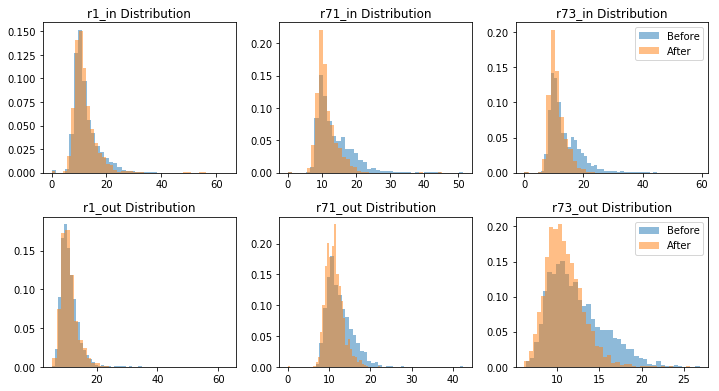

In [280]:
draw_histograms(Comb_median_b4,Comb_median_after,3,3)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  """


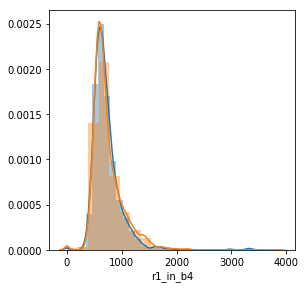

In [284]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(3,3,1)
sns.distplot(Comb_median_changes['r1_in_after'][~np.isnan(Comb_median_changes.r1_in_after)]
, bins = 30,ax = ax)
ax.hold(True)
sns.distplot(Comb_median_changes['r1_in_b4'][~np.isnan(Comb_median_changes.r1_in_b4)],
        bins=20,  ax = ax)

plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  import sys


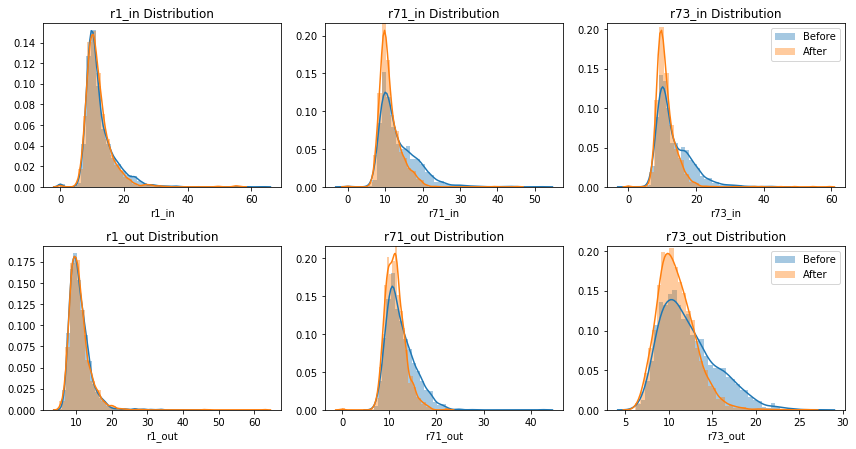

In [290]:
sns_histograms(Comb_median_b4,Comb_median_after,3,3)

## Interactive plot

In [ ]:
def one_histogram(df_b4,df_after):
    fig = plt.figure(figsize =(12,9))
    for i, var_name in enumerate(df_b4.columns):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        sns.distplot(df_b4[var_name][~np.isnan(df_b4[var_name])],
                bins = 40,label='Before')
        ax.hold(True)
        sns.distplot(df_after[var_name][~np.isnan(df_after[var_name])],
                bins = 40, label='After')

        ax.set_title(var_name+" Distribution")
        if (i+1)%3 == 0: ax.legend()
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()